I have used the following methods.

* I have implemented DeepLabv3+ stemmed from this Keras example[1,2],
* I converted the original masks to <b><span style="color:#e74c3c;"> binary masks and applied dilated operation </span></b> in the image preprocessing stage,
* I used <b><span style="color:#e74c3c;"> histogram equalization and smoothing</span></b> for original images in the image preprocessing stage,
* <b>Dice coefficient</b> and <b>Jaccard index</b> implementation[3],
* I used <b> <b><span style="color:#e74c3c;"> DeepLabv3+ implementation</span></b> with ResNet50 backbone,
* Used tf.data for input pipeline,
* <b>A Custom layer</b> for convolution operation,
* <b>A Custom layer</b> for Dilated Spatial Pyramid Pooling operation,
* <b>Custom callback</b> for predicting one sample from test dataset during training each epochs[4]

## Evaluation Results

| for 15 epochs    | Train (900 imgs) | Valid (135 imgs) | Test (100 imgs) |
|------------------|------------------|------------------|-----------------|
| Loss             | 0.0357           | 0.0399           | 0.2296          |
| Dice Loss        | 0.0657           | 0.0693           | 0.2111          |
| Dice Coefficient | 0.9343           | 0.9307           | 0.7889          |
| Jaccard Index    | 0.8770           | 0.8709           | 0.6601          |

    
## Model Improvement During Training
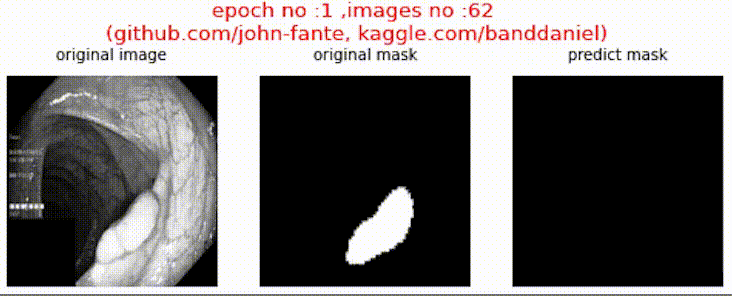
    
## Predictions
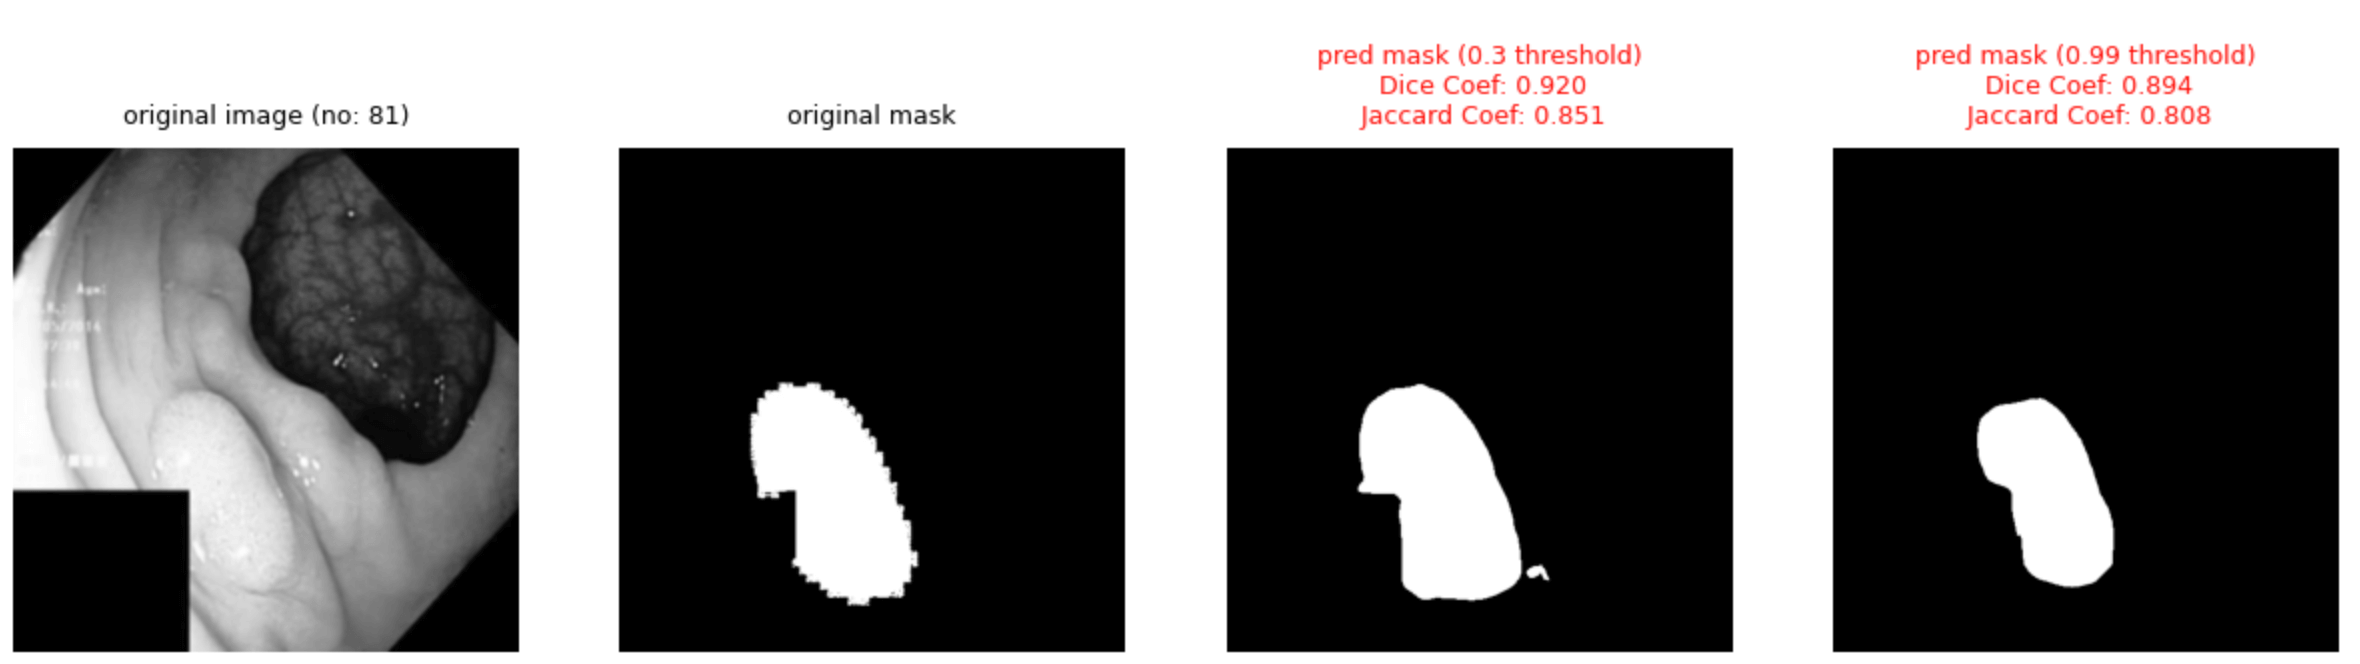
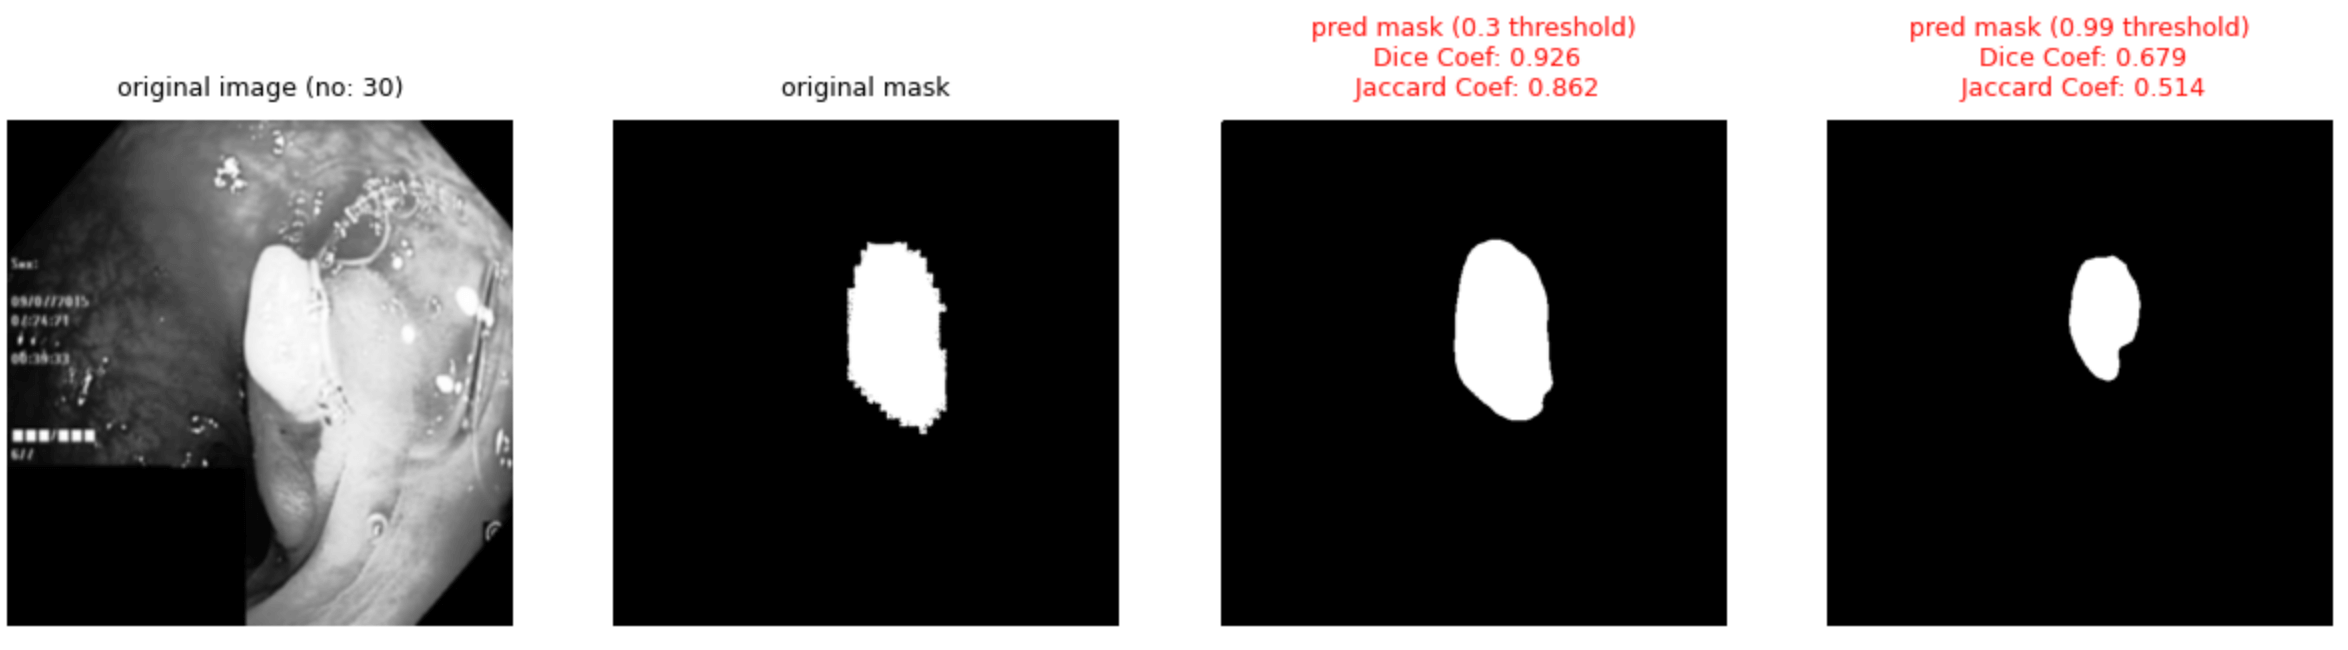


## My Another Segmentation Projects

* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Brain tumor/anomaly segmentation with Unet using TPU](https://github.com/john-fante/brain-tumor-segmentation-tpu)
* [Iris Segmentation U-net w/TPU (Dice Coef: 0.94)](https://www.kaggle.com/code/banddaniel/iris-segmentation-u-net-w-tpu-dice-coef-0-94)
* [Eye Conjunctiva Segmentation with U-Net using TPU (Dice: 0.91, Jaccard: 0.82)](https://github.com/john-fante/eye-conjunctiva-segmentation)
* [Brain tissue segmentation with Unet using TPU (Dice: 0.88)](https://github.com/john-fante/brain-tissue-segmentation-tpu)


## References
1. https://keras.io/examples/vision/deeplabv3_plus/#building-the-deeplabv3-model
2. Chen, L.-C., Zhu, Y., Papandreou, G., Schroff, F., & Adam, H. (2018). Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation (Version 3). arXiv. https://doi.org/10.48550/ARXIV.1802.02611
3. https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient
4. My another custom callbacks for Tensorflow (https://github.com/john-fante/my-tensorflow-custom-callbacks)

In [49]:
# Importing dependencies

import warnings
warnings.filterwarnings('ignore')
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout,Concatenate, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import Activation, MaxPooling2D, AveragePooling2D, Dense, concatenate, GlobalAveragePooling2D


SEED = 65
IMG_SIZE = 512,512
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE

# <span style="color:#e74c3c;"> Image </span> Preprocessing


In [6]:
# Corrected paths using raw strings
os.makedirs(os.path.join(r'C:\Users\elhou\OneDrive\Documents\PFE\Pycharm Projects\NN\WCE Segmentation\Dataset Seg', 'converted_masks'), exist_ok=True)
os.makedirs(os.path.join(r'C:\Users\elhou\OneDrive\Documents\PFE\Pycharm Projects\NN\WCE Segmentation\Dataset Seg', 'converted_images'), exist_ok=True)


In [7]:
# A function that is used for converting binary masks and dilated masks 

def convert_binary_masks(main_path, target_path):
    for i in sorted(os.listdir(main_path)):
        img = cv2.imread(os.path.join(main_path, i ))
        f, bw_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
        kernel = np.ones((2,2))
        dilated_mask = cv2.dilate(bw_img, kernel, iterations = 1)
        cv2.imwrite(os.path.join(target_path,i), dilated_mask[:,::,0])

In [8]:
# A function that is used for applying histogram equalization and smoothing with gaussian blur

def image_cvt_histeq_smooth(main_path, target_path):
    main_imgs = sorted(os.listdir(main_path))
    for i in main_imgs :

        img = cv2.imread(os.path.join(main_path, i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.equalizeHist(img)
        img = cv2.blur(img,(4,4))

        cv2.imwrite(os.path.join(target_path, i), img)

In [9]:
# Applying preprocessing functions to images and masks

convert_binary_masks('Dataset Seg/Kvasir-SEG/Kvasir-SEG/masks', 'Dataset Seg/converted_masks')
image_cvt_histeq_smooth('Dataset Seg/Kvasir-SEG/Kvasir-SEG/images', 'Dataset Seg/converted_images')

(-0.5, 618.5, 530.5, -0.5)

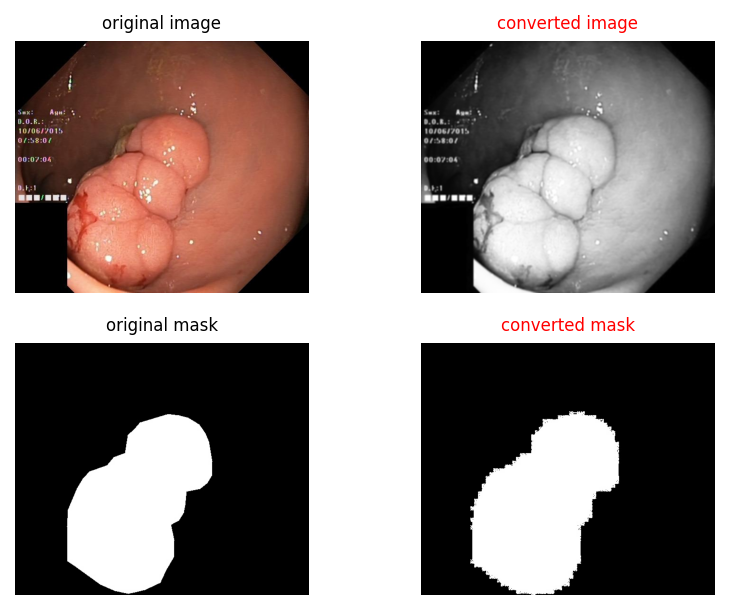

In [10]:
img_original = cv2.imread("Dataset Seg/Kvasir-SEG/Kvasir-SEG/images/cju8bbznkrf5g0871jncffynk.jpg")
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

mask_original = cv2.imread("Dataset Seg/Kvasir-SEG/Kvasir-SEG/masks/cju8bbznkrf5g0871jncffynk.jpg")


img_converted =cv2.imread('Dataset Seg/converted_images/cju8bbznkrf5g0871jncffynk.jpg') 
mask_converted =cv2.imread('Dataset Seg/converted_masks/cju8bbznkrf5g0871jncffynk.jpg') 


fig, ax = plt.subplots(2,2, dpi = 150)
ax[0][0].imshow(img_original)
ax[0][0].set_title('original image', fontsize = 8)
ax[0][0].axis('off')

ax[0][1].imshow(img_converted)
ax[0][1].set_title('converted image', fontsize = 8, color = 'red')
ax[0][1].axis('off')

ax[1][0].imshow(mask_original)
ax[1][0].set_title('original mask', fontsize = 8)
ax[1][0].axis('off')

ax[1][1].imshow(mask_converted)
ax[1][1].set_title('converted mask', fontsize = 8, color = 'red')
ax[1][1].axis('off')

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [11]:
# Creating main dataframe contains image paths and their mask paths.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))

    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path


images = create_images_list('Dataset Seg/converted_images')
masks = create_images_list('Dataset Seg/converted_masks')

full_data = pd.DataFrame({'image': images, 'mask': masks})

full_data = shuffle(full_data).reset_index().drop(columns=['index'])

# <span style="color:#e74c3c;"> Creating </span> Train, Val, Test Datasets


In [12]:
X_data, X_test, y_data, y_test = train_test_split(full_data['image'], full_data['mask'], test_size = 0.1, random_state = SEED)
X_train, X_validation, y_train, y_validation = train_test_split(X_data, y_data, test_size = 0.15, random_state = SEED + 1)

print("X_train shape -> ", X_data.shape)
print("X_val shape -> ", X_validation.shape)
print("X_test shape -> ", X_test.shape)

X_train shape ->  (900,)
X_val shape ->  (135,)
X_test shape ->  (100,)


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [13]:
# Reading and resizing images and masks

def img_preprocessing(image, mask):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_jpeg(mask, channels = 1)
    mask = tf.image.resize(mask, size = (IMG_SIZE))
    mask = tf.cast(mask, tf.float32) / 255.0
    
    return img, mask


In [14]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((X_data, y_data))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .shuffle(X_data.shape[0])
                 .prefetch(AUTO))


validation_loader = tf.data.Dataset.from_tensor_slices((X_validation, y_validation))
validation_dataset = (validation_loader
                      .map(img_preprocessing, num_parallel_calls = AUTO)
                      .batch(BATCH_SIZE)
                      .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

# <span style="color:#e74c3c;"> Creating </span> Custom Layers

In [15]:
# Convolutional block class

class ConvBlock(Layer):
    def __init__(self, filters, kernel_size, dilation_rate, batch = False, padding = 'same', activation = 'relu', use_bias = False, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.batch = batch
        self.padding = padding
        self.activation = activation
        self.use_bias = use_bias
        
        self.conv = Conv2D(filters, kernel_size = kernel_size, dilation_rate = dilation_rate, padding = padding, use_bias = use_bias, kernel_initializer = 'he_normal')
        self.norm = BatchNormalization()
        self.act = Activation(activation)
    
    def call(self, inputs):
        X = self.conv(inputs)
        if self.batch:
            X = self.norm(X)
            X = self.act(X)
            return X
        else:
            X = self.act(X)
            return X
            

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size" : self.kernel_size,
            "dilation_rate" : self.dilation_rate,
            "activation" : self.act,
            "batch" : self.batch }


In [16]:
# DilatedSpatialPyramidPooling class for DeepLabv3+ model

class DilatedSpatialPyramidPooling(Layer):
    def __init__(self, input_layer, kernel_1, kernel_2, kernel_3, kernel_4, dil1, dil2, dil3, dil4, **kwargs):
        super(DilatedSpatialPyramidPooling, self).__init__(**kwargs)
        self.input_layer = input_layer
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2
        self.kernel_3 = kernel_3
        self.kernel_4 = kernel_4
        self.dil1 = dil1
        self.dil2 = dil2
        self.dil3 = dil3
        self.dil4 = dil4
 
        self.pool = AveragePooling2D(pool_size = (input_layer.shape[-3], input_layer.shape[-2]))
        self.convblock = ConvBlock(filters = 256, kernel_size=1, dilation_rate=1, batch = True, use_bias=True)
        self.outpool = UpSampling2D(size=(32,32), interpolation="bilinear")
        self.convout1 = ConvBlock(filters = 256, kernel_size = kernel_1, dilation_rate = dil1, batch = True)
        self.convout2 = ConvBlock(filters = 256, kernel_size = kernel_2, dilation_rate = dil2, batch = True)
        self.convout3 = ConvBlock(filters = 256, kernel_size = kernel_3, dilation_rate = dil3, batch = True)
        self.convout4 = ConvBlock(filters = 256, kernel_size = kernel_4, dilation_rate = dil4, batch = True)
        self.outconv = ConvBlock(filters = 256, kernel_size = 1, dilation_rate=1, batch = True)

    
    def call(self, inputs):
        X = self.pool(inputs)
        X = self.convblock(X)
        X_p = self.outpool(X)
        X_1 = self.convout1(inputs)
        X_2 = self.convout2(inputs)
        X_3 = self.convout3(inputs)
        X_4 = self.convout4(inputs)
        
        C = concatenate([X_p, X_1, X_2, X_3, X_4], axis = -1)
        X = self.outconv(C)
        return X

    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "input_layer": self.input_layer,
            "kernel_1" : self.kernel_1,
            "kernel_2" : self.kernel_2,
            "kernel_3" : self.kernel_3,
            "kernel_4" : self.kernel_4,
            "dil1" : self.dil1,
            "dil2" : self.dil2,
            "dil3" : self.dil3,
            "dil4" : self.dil4}

In [17]:
# Creating Dice and Jaccard metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def jaccard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1e-6 )
    return jaccard

In [18]:
# Custom callback for predicting one sample from test dataset during training each epochs

class PredictDuringTraining(Callback):
    def on_epoch_end(self, epochs, logs = None ):
        
        if (epochs + 1) % 1 == 0:
            samples = list(test_dataset.take(-1))
        
            idxs = np.random.permutation(X_test.shape[0])[0]
            batch_idx = idxs // BATCH_SIZE
            image_idx = idxs-batch_idx * BATCH_SIZE
            idx = idxs
        
            image = samples[batch_idx][0][image_idx] 
            mask = samples[batch_idx][1][image_idx]
        
            pred_mask = self.model.predict(image[np.newaxis,...], verbose = 0)
            pred_ = np.squeeze(pred_mask)
            threshold  = 0.3
            bitmap_pred = (pred_ > threshold).astype(np.uint8)
        
            fig, axs = plt.subplots(1,3, figsize = (5,2) ,dpi = 120)
            fig.suptitle( 'epoch no :' + str(epochs + 1)  + ' ,images no :' + str(idx) + '\n (github.com/john-fante, kaggle.com/banddaniel)', color='red', fontsize = 8 )

            axs[0].imshow(image , cmap = 'gray')
            axs[0].axis('off')
            axs[0].set_title('original image', fontsize = 6)

            axs[1].imshow(mask, cmap = 'gray')
            axs[1].axis('off')
            axs[1].set_title('original mask', fontsize = 6)

            axs[2].imshow( bitmap_pred, cmap = 'gray')
            axs[2].axis('off')
            axs[2].set_title('predict mask', fontsize = 6)
                            
            plt.tight_layout()
            plt.show()
        else:
            pass

# <span style="color:#e74c3c;"> DeepLabv3+</span> Model


In [19]:
inp = Input(shape = (*IMG_SIZE ,3))
pretrained = ResNet50(weights="imagenet", include_top=False, input_tensor=inp)
X = pretrained.get_layer("conv4_block6_2_relu").output
X = DilatedSpatialPyramidPooling(X, kernel_1 = 1, kernel_2 = 3, kernel_3 = 3, kernel_4 = 3,
                                 dil1 = 1, dil2 = 6, dil3 = 12, dil4 = 18)(X)

X_1 = UpSampling2D(size = (IMG_SIZE[0] // 4 // X.shape[1], IMG_SIZE[0] // 4 // X.shape[2]), interpolation="bilinear")(X)

X_2 = pretrained.get_layer("conv2_block3_2_relu").output
X_2 = ConvBlock(filters=48, kernel_size=1, dilation_rate =1)(X_2)

X = Concatenate(axis=-1)([X_1, X_2])
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = UpSampling2D(size = (IMG_SIZE[0] // X.shape[1], IMG_SIZE[0] // X.shape[2]), interpolation="bilinear")(X)

out = Conv2D(1, 1 ,activation ='sigmoid', padding = 'same')(X)

model = Model(inputs = inp, outputs = out)
#model.summary()
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy' , metrics = [dice_coef_loss, dice_coef, jaccard]) 
my_callbacks = [PredictDuringTraining()]

# <span style="color:#e74c3c;"> Training </span> 


In [20]:
hist = model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = 15, validation_data = validation_dataset, callbacks = my_callbacks)

Epoch 1/15
 18/113 [===>..........................] - ETA: 28:31 - loss: 0.5927 - dice_coef_loss: 0.7474 - dice_coef: 0.2526 - jaccard: 0.1484

KeyboardInterrupt: 

In [21]:
# Skip the training phase



# Instead of training, load the weights
# Assuming you have already downloaded the weights file from Kaggle to your local machine
weights_path = 'model/model_weights.h5'  

# Load the weights into the model
model.load_weights(weights_path)

# Now, the model is ready to use with the pre-trained weights
# You can use the model to make predictions or evaluate it on new data

# Example: Evaluate the model on the test dataset
test_loss, test_dice_coef_loss, test_dice_coef, test_jaccard = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient Loss: {test_dice_coef_loss}")
print(f"Test Dice Coefficient: {test_dice_coef}")
print(f"Test Jaccard Index: {test_jaccard}")

# Example: Make predictions on new data
# Ensure the new data is preprocessed similarly to your training data
# new_data = ...  # load and preprocess your new data
# predictions = model.predict(new_data)


13/13 [==============================] - 41s 3s/step - loss: 0.0886 - dice_coef_loss: 0.1168 - dice_coef: 0.8832 - jaccard: 0.7924
Test Loss: 0.08860216289758682
Test Dice Coefficient Loss: 0.1167614534497261
Test Dice Coefficient: 0.8832385540008545
Test Jaccard Index: 0.7923934459686279


# <span style="color:#e74c3c;"> Training </span> Results, Evaluation

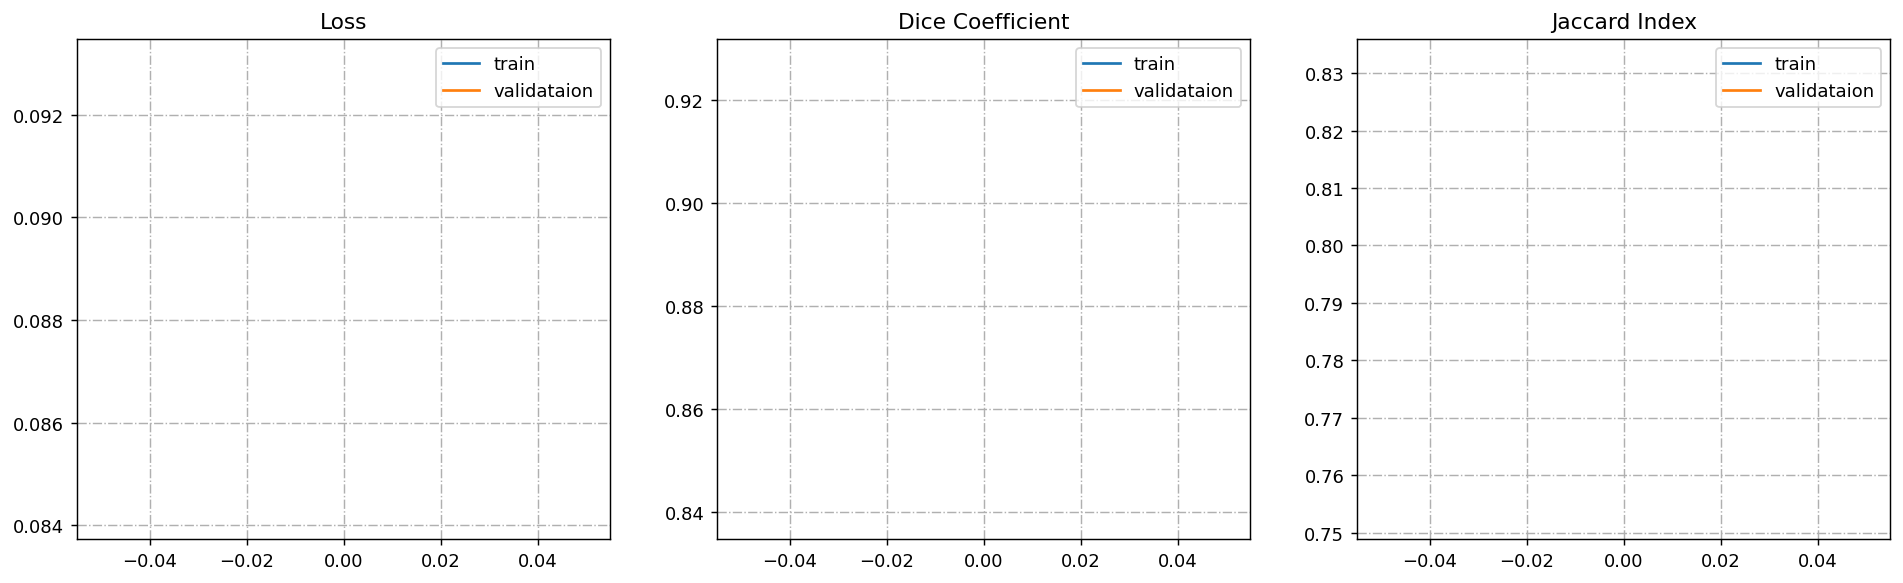

In [24]:
fig, axs = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].legend(["train", "validataion"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Dice Coefficient")
axs[1].plot(hist.history['dice_coef'])
axs[1].plot(hist.history['val_dice_coef'])
axs[1].legend(["train",  "validataion"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Jaccard Index")
axs[2].plot(hist.history['jaccard'])
axs[2].plot(hist.history['val_jaccard'])
axs[2].legend(["train",  "validataion"])

# <span style="color:#e74c3c;"> Test and Validation </span> Evaluation

In [25]:
val_eval = model.evaluate(validation_dataset)
test_eval = model.evaluate(test_dataset)

13/13 [==============================] - 40s 3s/step - loss: 0.0886 - dice_coef_loss: 0.1168 - dice_coef: 0.8832 - jaccard: 0.7924


# <span style="color:#e74c3c;"> Test </span> Predictions

In [26]:
test_take1 =  validation_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())
    
pred_ = np.squeeze(pred)

threshold_1  = 0.3 #threshold for prediction
bitmap_pred_1 = (pred_ > threshold_1).astype(np.uint8)

threshold_2  = 0.99 #threshold for prediction
bitmap_pred_2 = (pred_ > threshold_2).astype(np.uint8)

17/17 [==============================] - 55s 3s/step


In [27]:
# A function that calculating dice and jaccard metrics for prediction
def calc_dice_jaccard_for_prediction(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = tf.cast(y_true_f, tf.uint16)
    y_pred_f = tf.cast(y_pred_f, tf.uint16)

    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)
    
    return dice.numpy(),jaccard.numpy()


# A function that creating 3 random images in the test set and prediction it
def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(y_test_take))[:3]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

   
    fig, axs = plt.subplots(3,4, figsize = (10, 10 ) ,dpi = 150)
    
    for i in range(3):
        image = test_take1_[batch_idx[i]][0][image_idx[i]]
        mask = test_take1_[batch_idx[i]][1][image_idx[i]]
        pred_mask_1 = bitmap_pred_1[idx[i]]
        pred_mask_2 = bitmap_pred_2[idx[i]]
        
        dice1 = calc_dice_jaccard_for_prediction(mask, pred_mask_1)[0]
        jac1 = calc_dice_jaccard_for_prediction(mask, pred_mask_1)[1]
        
        dice2= calc_dice_jaccard_for_prediction(mask, pred_mask_2)[0]
        jac2= calc_dice_jaccard_for_prediction(mask, pred_mask_2)[1]
        

        axs[i][0].imshow(image , cmap = 'gray')
        axs[i][0].axis('off')
        axs[i][0].set_title('original image (no: ' + str(idxs[i]) + ")", fontsize = 6)

        axs[i][1].imshow(mask, cmap = 'gray')
        axs[i][1].axis('off')
        axs[i][1].set_title('original mask', fontsize = 6)

        axs[i][2].imshow(pred_mask_1 , cmap = 'gray')
        axs[i][2].axis('off')
        axs[i][2].set_title('pred mask (0.3 threshold)'
                            + '\n Dice Coef: {0:0.3f}'.format(dice1) 
                            + '\n Jaccard Coef: {0:0.3f}'.format(jac1), color = 'red', fontsize = 6)
    
        axs[i][3].imshow(pred_mask_2 , cmap = 'gray')
        axs[i][3].axis('off')
        axs[i][3].set_title('pred mask (0.99 threshold)' + '\n Dice Coef: {0:0.3f}'.format(dice2) + '\n Jaccard Coef: {0:0.3f}'.format(jac2), color = 'red', fontsize = 6)

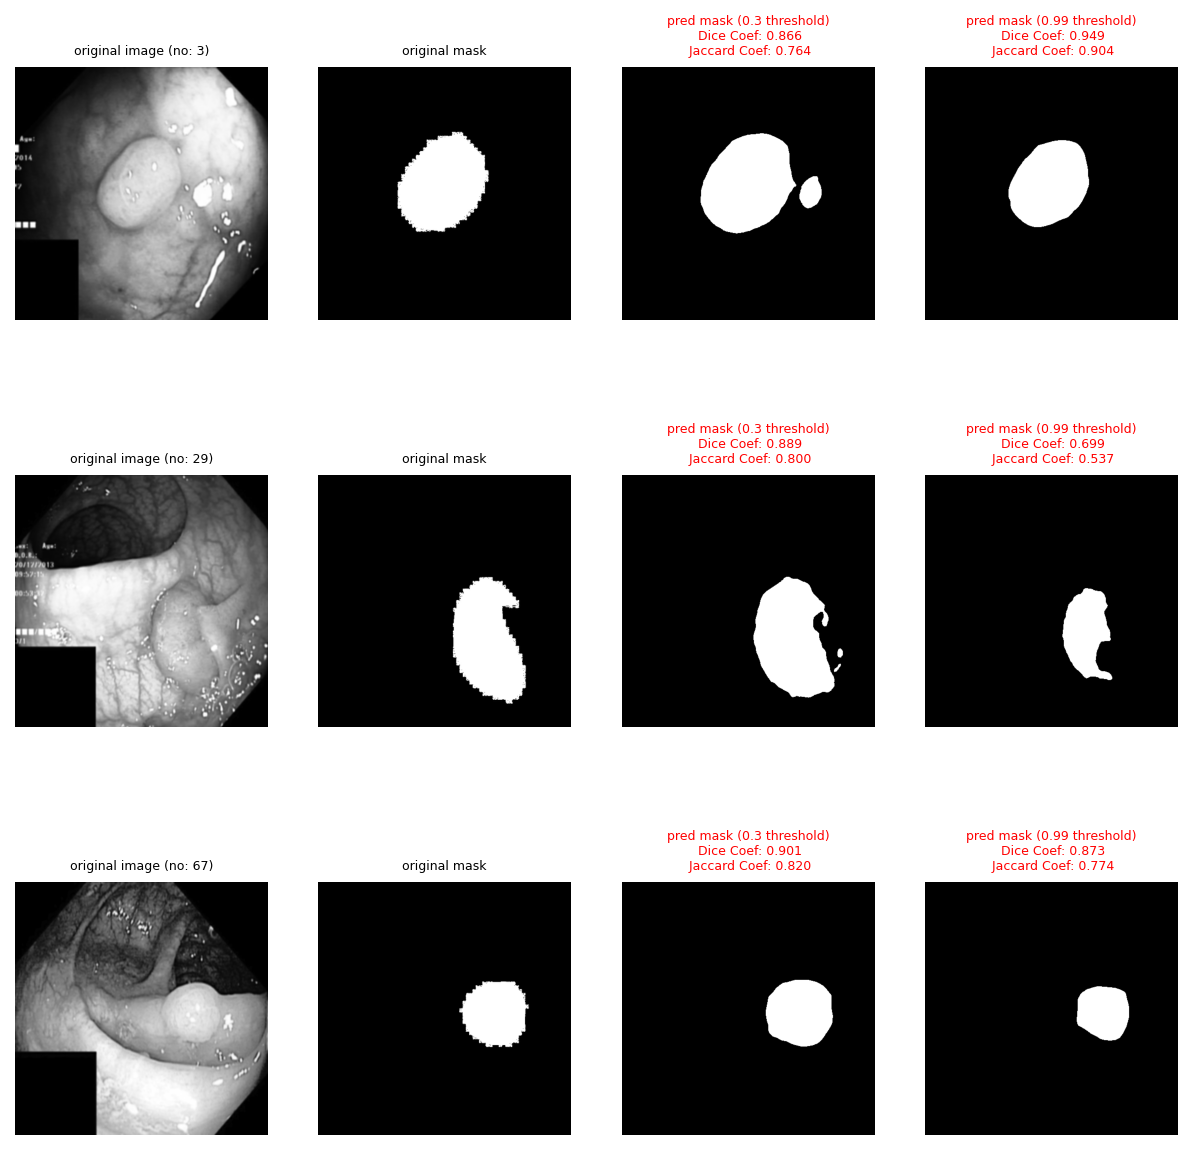

In [28]:
random_test_sample_with_prediction()

In [27]:
# Save weights
model.save_weights('/kaggle/working/model_weights.h5')

# Assuming you can reconstruct the model from a script, you only need to load weights later
# If you need to save configuration, serialize it manually in a way that avoids the problematic serialization


In [38]:
# Pass a sample input to build the model
sample_input = np.random.rand(1, *IMG_SIZE, 3).astype(np.float32)
_ = model(sample_input)


In [40]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
        layer.trainable = True

In [45]:
try:
    model.save('model/saved_model_directory', save_format='tf')
    print("Model saved successfully.")
except Exception as e:
    print("Error saving the model:", str(e))


INFO:tensorflow:Assets written to: model/saved_model_directory\assets


INFO:tensorflow:Assets written to: model/saved_model_directory\assets


Error saving the model: Unable to serialize KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='conv4_block6_2_relu/Relu:0', description="created by layer 'conv4_block6_2_relu'") to JSON. Unrecognized type <class 'keras.engine.keras_tensor.KerasTensor'>.


1/1 [==============================] - 0s 497ms/step


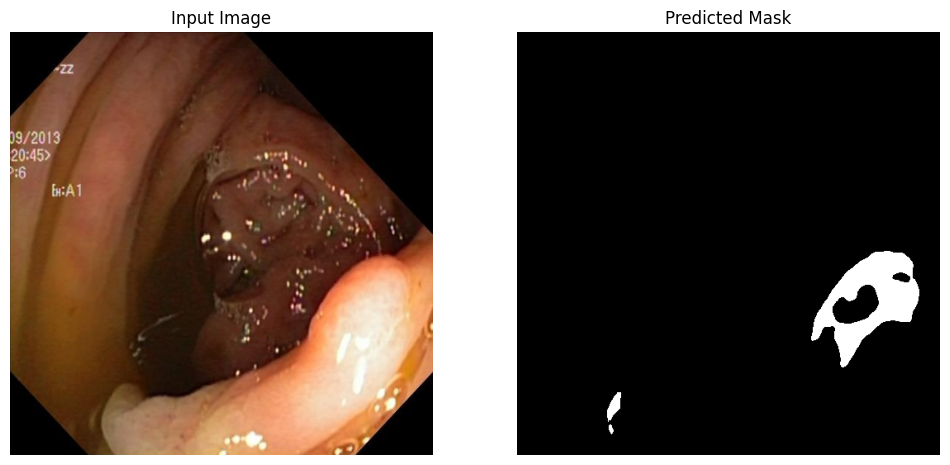

In [54]:
# <span style="color:#e74c3c;"> Predicting on Specific Images </span>

# Define the path to the specific image you want to predict
specific_image_path = 'Dataset Seg/Kvasir-SEG/Kvasir-SEG/images/cju0sxqiclckk08551ycbwhno.jpg'  # Replace with your image path


# Function to load and preprocess the image
def preprocess_image(image_path, img_size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, img_size)  # Resize to match the model's input size
    image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]
    return image


# Function to predict the mask for a given image
def predict_image(model, image_path, img_size):
    # Preprocess the image
    image = preprocess_image(image_path, img_size)
    # Add batch dimension
    image_batch = np.expand_dims(image, axis=0)
    # Predict the mask
    pred_mask = model.predict(image_batch)
    # Squeeze out the batch dimension and channel dimension
    pred_mask = np.squeeze(pred_mask)
    # Convert predictions to binary mask
    threshold = 0.5  # Set threshold to binarize the mask
    pred_binary_mask = (pred_mask > threshold).astype(np.uint8)
    return image, pred_binary_mask


# Perform the prediction
input_image, predicted_mask = predict_image(model, specific_image_path, IMG_SIZE)

# Visualize the input image and its predicted mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(input_image)
ax[0].set_title('Input Image')
ax[0].axis('off')

ax[1].imshow(predicted_mask, cmap='gray')
ax[1].set_title('Predicted Mask')
ax[1].axis('off')

plt.show()


In [51]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.12.0


In [55]:
# <span style="color:#e74c3c;"> Gradio Interface for Image Segmentation </span>

import gradio as gr


# Function to preprocess the image and predict the mask
def predict_and_visualize(image):
    # Resize and normalize the image
    image_resized = cv2.resize(image, IMG_SIZE)
    image_normalized = image_resized.astype(np.float32) / 255.0
    image_batch = np.expand_dims(image_normalized, axis=0)

    # Predict the mask
    pred_mask = model.predict(image_batch)
    pred_mask = np.squeeze(pred_mask)

    # Convert predictions to binary mask
    threshold = 0.5  # Threshold for binary mask
    pred_binary_mask = (pred_mask > threshold).astype(np.uint8)

    return pred_binary_mask


# Gradio interface definition
def segment_image(image):
    # Convert PIL image to NumPy array
    image_array = np.array(image)

    # Predict the mask
    pred_mask = predict_and_visualize(image_array)

    return pred_mask


# Create a Gradio Interface
gr_interface = gr.Interface(
    fn=segment_image,  # The function to run
    inputs=gr.Image(type="numpy"),  # The input component, now use `gr.Image`
    outputs=gr.Image(type="numpy", label="Predicted Mask"),  # The output component
    title="DeepLabv3+ Image Segmentation",
    description="Upload an image to get the predicted segmentation mask using DeepLabv3+.",
    live=True  # Enable live interaction
)

# Launch the Gradio interface
gr_interface.launch()


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
